# **Title:** Model Validation

**Aim:**

*   To validate the model by testing it with a new and unseen dataset while looking out for how well it can generalize on new data. We will also be doing this in both Ersilia-eos6oli and SolTranNet.

**Source:**

*   All the datasets used for this task were obtained from the [GitHub repository](https://github.com/francoep/SolTranNet_paper/blob/main/README.md) provided in the publication.





*By Nwuguru Chidiebere Sullivan*



---



# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from prettytable import PrettyTable
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, auc, roc_auc_score, roc_curve
import glob
sys.path.append('/content/drive/MyDrive/ersilia/src')


In [2]:
!pip install rdkit
!pip install standardiser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.4/698.4 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for standardiser: filename=standardiser-0.1.9-py3-none-any.whl size=720101 sha256=ed0ab0c5ab9f7c1a1035c50e069440d43d5a31ea9b4da0e7fb714953ffde3a96
  Stored in directory: /root/.cache/pip/wheels/eb/62/4b/6044430bf5a732d53bd0d1aa165c928954d9f87cd92529f00f
Successfully built standardiser




---



# Getting The Overview Of The Data

In [3]:
# @title 🗂️ Let's mount our Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**🛠️ Setting up folders and paths:**

In [4]:
#specify input folder
input_folder = '/content/drive/MyDrive/ersilia/data/llinas2020/'

#specify the name of the input file
input_filename = "llinas2020_set1_test"

#specify the name of the SMILE column
smiles_column = 'smiles'


In [5]:
# @title 🔃 Let's load our dataset into a DataFrame and have a view of it
llinas_df = pd.read_csv('/content/drive/MyDrive/ersilia/data/llinas2020/llinas2020_set1_test.csv')
llinas_df.head()

,smiles,y
0,CC(NC1=NN=C(S1)[S](N)(=O)=O)=O,-2.38
1,C(C)(=O)OC1=CC=CC=C1C(=O)O,-1.67
2,C=CCOc1ccc(cc1Cl)CC(=O)O,-4.40
3,O[C@@H]2CC[C@@H](NCc1cc(Br)cc(Br)c1N)CC2,-3.87
4,O=C1Nc2c(ccc(OCCCCN3CCN(c4c(Cl)c(Cl)ccc4)CC3)c...,-6.64


In [6]:
#let's get the info about our data
llinas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  100 non-null    object 
 1   y       100 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [7]:
#let's check for missing values
llinas_df.isnull().sum()

smiles    0
y         0
dtype: int64

In [8]:
#let's check for duplicates
llinas_df.duplicated().sum()

0

In [9]:
# @title Let's check how many smiles😄 we have in our data
smiles = llinas_df[smiles_column].tolist()

print(f"My dataset contains {str(len(smiles)) + ' ' + 'SMILES'}")

My dataset contains 100 SMILES


In [10]:
# @title Let's confirm if all the smiles😄 are valid
from rdkit import Chem

def is_smiles(smiles):
    return Chem.MolFromSmiles(smiles) is not None
all_valid = all(is_smiles(i) for i in smiles)

if all_valid:
    print("All samples are valid SMILES")
else:
    print("Not all samples are valid SMILES")

All samples are valid SMILES




---



# Section A: SolTranNet

*   In this section, we will be implementing the unseen data in SolTranNet.
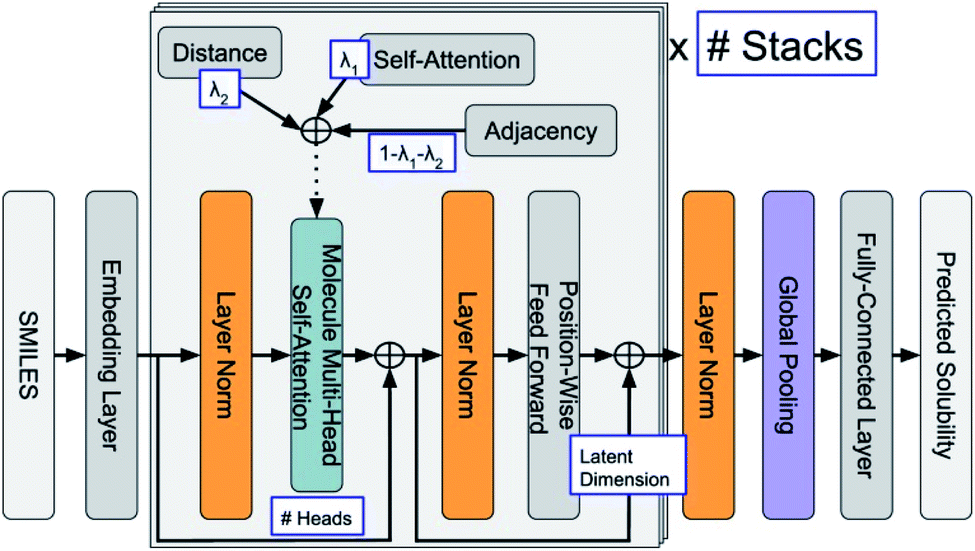







**Let's install and import the model, Soltranet:**

In [11]:
#install rdkit
!pip install rdkit

#install SolTranet
!pip install soltrannet

#import soltranet
import soltrannet as stn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 976.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [12]:
# @title Let's start by testing a simple prediction on the model(SolTranet) to be sure the model is working properely
my_smiles=["c1ccccc1","c1ccccc1 .ignore","Cn1cnc2n(C)c(=O)n(C)c(=O)c12","[Zn+2]","[Na+].[Cl-]"]
pred=list(stn.predict(my_smiles))
pred

[(-1.052748441696167, 'c1ccccc1', ''),
 (-1.052748441696167, 'c1ccccc1 .ignore', ''),
 (-1.1322435140609741, 'Cn1cnc2n(C)c(=O)n(C)c(=O)c12', ''),
 (-6.881844520568848,
  '[Zn+2]',
  'Other-typed Atom(s) Detected Prediction less reliable'),
 (-0.16869044303894043,
  '[Na+].[Cl-]',
  'Salt Other-typed Atom(s) Detected Prediction less reliable')]

Yeah! The model is working properely😊

**Let's run predictions on the unseen_data(llinas_df) with SolTranNet:**

In [13]:
#let's run a prediction on the smiles column of the dataset using our model
predictions = list(stn.predict(smiles))

#let's the first 10 values of our predictions
predictions[:10]

[(-1.2419066429138184, 'CC(NC1=NN=C(S1)[S](N)(=O)=O)=O', ''),
 (-1.857985258102417, 'C(C)(=O)OC1=CC=CC=C1C(=O)O', ''),
 (-3.119774103164673, 'C=CCOc1ccc(cc1Cl)CC(=O)O', ''),
 (-2.1994705200195312, 'O[C@@H]2CC[C@@H](NCc1cc(Br)cc(Br)c1N)CC2', ''),
 (-5.205143928527832,
  'O=C1Nc2c(ccc(OCCCCN3CCN(c4c(Cl)c(Cl)ccc4)CC3)c2)CC1',
  ''),
 (-6.521167755126953, 'O=C1c2ccccc2C(=O)C(O)=C1C1CCC(CC1)c1ccc([Cl])cc1', ''),
 (-2.817272663116455, 'CCNc1nc(nc(n1)Cl)NC(C)C', ''),
 (-1.7760666608810425, 'C1=CC(=CC=C1C(CC(O)=O)CN)Cl', ''),
 (-1.8396010398864746, 'CCC(C)C1(C(=O)NC(=O)NC1=O)CC', ''),
 (-4.210572719573975,
  'C1=C(Cl)C(=CC2=C1NC(=N[S]2(=O)=O)CSCC3=CC=CC=C3)[S](N)(=O)=O',
  '')]

**Let's save the predictions from SolTranNet into a CSV file**

In [14]:
# Add predictions to the input DataFrame
n_pred  = [p[0] for p in predictions]
llinas_df['solubility'] = n_pred

# Write the updated DataFrame with predictions to a new CSV file
path = '/content/drive/MyDrive/ersilia/data/Soltranet_vali_output.csv'
llinas_df.to_csv(path, sep=',', index=False, encoding='utf-8')


**Let's load the file we just save into a dataframe we shall be working further with**

In [15]:
soltra_df = pd.read_csv('/content/drive/MyDrive/ersilia/data/Soltranet_vali_output.csv')
soltra_df.head()

,smiles,y,solubility
0,CC(NC1=NN=C(S1)[S](N)(=O)=O)=O,-2.38,-1.241907
1,C(C)(=O)OC1=CC=CC=C1C(=O)O,-1.67,-1.857985
2,C=CCOc1ccc(cc1Cl)CC(=O)O,-4.40,-3.119774
3,O[C@@H]2CC[C@@H](NCc1cc(Br)cc(Br)c1N)CC2,-3.87,-2.199471
4,O=C1Nc2c(ccc(OCCCCN3CCN(c4c(Cl)c(Cl)ccc4)CC3)c...,-6.64,-5.205144


# **Model's(SolTranNet) Bias Evaluation**

(i) ***visualising the distribution of predicted solubility with a pie chart:***

In [16]:
#let's import a function called solubility_category which will help categorise the solubility values
from functions import solubility_category

*Important background note about the function, solubility_category:*

*   The function, 'solubility_category', which is stored in the [src folder](https://github.com/Nwuguru-Chidiebere-Sullivan/Outreachy-Ersilia-Project-Week2-Tasks/blob/main/src/functions.py), is defined based on the context of the solubility values evaluations as described in the publication, which implies that:
> compounds whose Log of Solibulity(LogS) values are within the range of 0 and above are classified as highly soluble compounds, those whose LogS values are within the range of 0 to –2 are classified as soluble compounds, while those whose LogS values are within the range of –2 to –4 are classified as slightly soluble compounds, and those with LogS values below –4 as insoluble compounds.






Slightly Soluble    58
Insoluble           35
Soluble              7
Name: solubility_cat, dtype: int64


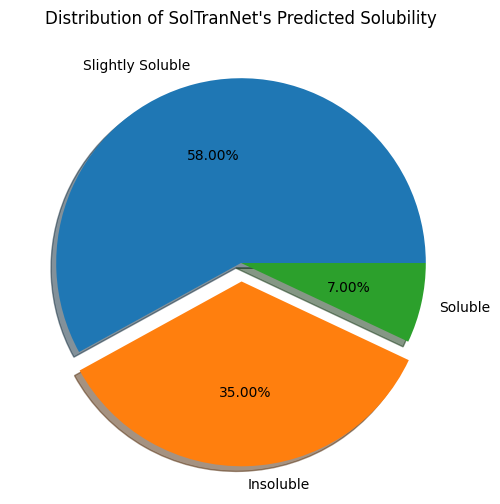

In [17]:
#copy the dataframe
df = soltra_df.copy()

# apply the solub function to create a new column
df['solubility_cat'] = df['solubility'].apply(solubility_category)

#let's visualize the distribution according to their degree of solubility
degree_of_solubility = df.solubility_cat.value_counts()
print(degree_of_solubility)

#create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    labels = degree_of_solubility.index,
    x = degree_of_solubility.values,
    shadow=True,
    autopct = "%.2f%%",
    explode = (0, 0.1,0)
)
plt.title("Distribution of SolTranNet's Predicted Solubility")
plt.savefig('/content/drive/MyDrive/ersilia/figures/sol_vali_pie_chart.png')
plt.show();

***COMMENTS:***

*   From the pie chart distribution, we can see that the solubility of the compound predicted by the SolTranNet model is slightly soluble.
*   Also, it appears there are no compounds that are highly soluble. We will confirm that with a histogram plot.



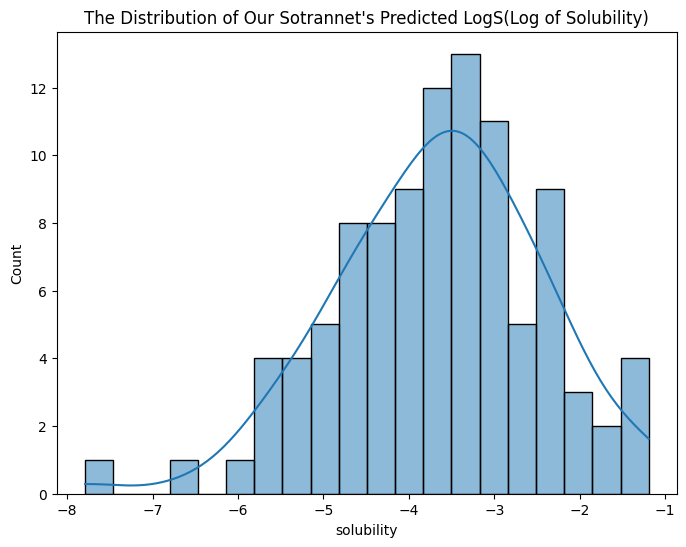

In [18]:
# @title 📊 Let's employ a histogram plot to visualize the distribution of our predictions
fig = plt.figure(figsize=(8,6))
sns.histplot(data=soltra_df, x='solubility', bins=20, kde=True)
plt.title("The Distribution of Our Sotrannet's Predicted LogS(Log of Solubility)")
plt.savefig('/content/drive/MyDrive/ersilia/figures/sol_vali_hist_plot.png')
plt.show();

***COMMENTS:***

* The majority of the compounds are distributed within the range –2 and –4, and this implies that there are more compounds that are slightly soluble.

*   Also, as the pie chart suggested, we have no single compound that is highly soluble (within the range of 0 and above).

*   However, the values are not normally distributed around middle and slightly towards the right, hence, with more tunning, the model can perform better.






---



# **Model's(SolTranNet) Performance Evaluation:**

In this section, we will:

*   evaluate SolTranNet's performance with its prediction by comparing it with the actual values through suitable visualisations.

*   evaluate SolTranNet with different performance metrics such as Mean Absolute Error, Mean Squared Error, Root Mean Squared Error, and R_Squared Score

*   evaluate the AUROC score and ROC curve of SolTranNet after having been factored to classify the predicted solubility; we will do this across two different solubility thresholds which are; less than –4, and greater than or equal to –4.




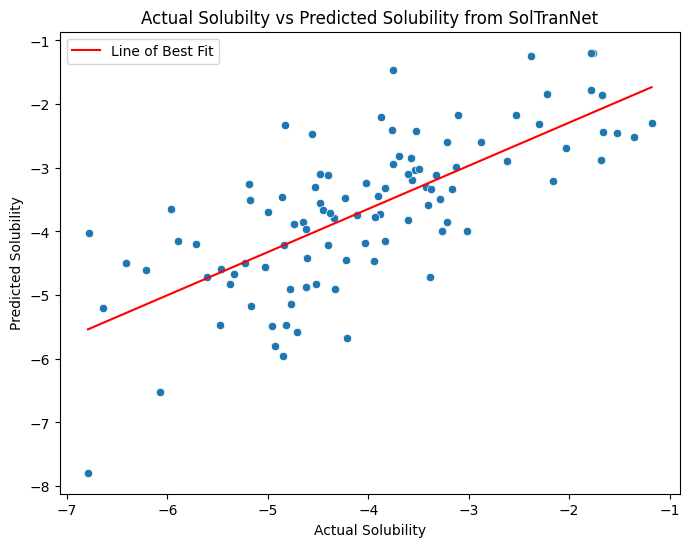

In [19]:
# @title Let's generate a scatter plot to show how closely related our model's predictions are to the actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='y', y='solubility', data=soltra_df)

#import LinearRegression
from sklearn.linear_model import LinearRegression

# adding a line of best fit
model = LinearRegression()
model.fit(soltra_df[['y']], soltra_df['solubility'])
x_values = np.linspace(soltra_df['y'].min(), soltra_df['y'].max(), 100)
y_values = model.predict(x_values.reshape(-1, 1))
plt.plot(x_values, y_values, color='red', label='Line of Best Fit')

plt.title('Actual Solubilty vs Predicted Solubility from SolTranNet')
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubility')

plt.legend()
plt.savefig('/content/drive/MyDrive/ersilia/figures/sol_vali_scatter_plot.png')
plt.show()

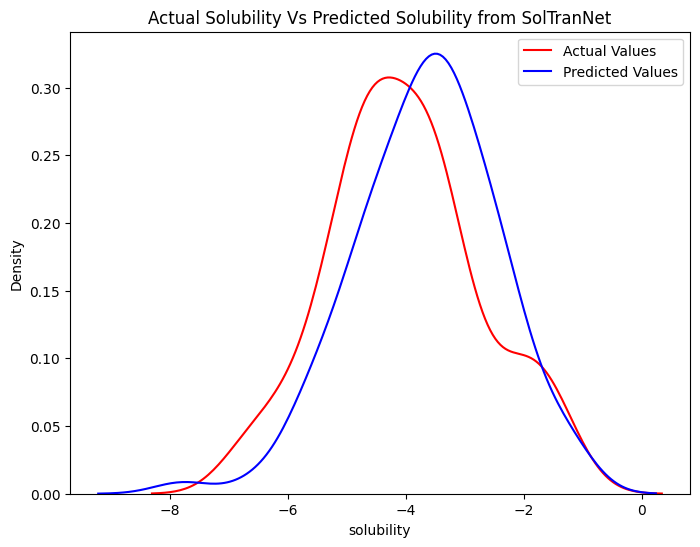

In [20]:
# @title 📈 Let's further visualize how close the SolTranNet's predictions are to the actual values using distplot
fig = plt.figure(figsize=(8,6))
ax = sns.distplot(soltra_df['y'], color='r', label='Actual Values', hist=False)
sns.distplot(soltra_df['solubility'], color='b', label='Predicted Values', hist=False, ax=ax)
plt.title('Actual Solubility Vs Predicted Solubility from SolTranNet')
plt.legend()
plt.savefig('/content/drive/MyDrive/ersilia/figures/sol_vali_dist_plot.png')
plt.show();

*Comments:*

*   From both the scatter plot and dist plot, we can see that our predicted values are close to the actual values, however, the proximity is not highly pronounced, hence, with proper model tuning, the prediction can become better and closer.



In [21]:
# @title Let's evaluate SolTranNet's performance metrics

MAE = mean_absolute_error(soltra_df['y'], soltra_df['solubility'])
MSE = mean_squared_error(soltra_df['y'], soltra_df['solubility'])
RMSE = np.sqrt(MSE)
R2_Score = r2_score(soltra_df['y'], soltra_df['solubility'])

print(f'MAE: {MAE:.2f}')
print(f'MSE: {MSE:.2f}')
print(f'RMSE: {RMSE:.2f}')
print(f'R2_Score: {R2_Score:.2f}')

MAE: 0.79
MSE: 0.98
RMSE: 0.99
R2_Score: 0.39


*Comments:*

*   Our model's(SolTranNet) performance metrics such as MSE, and RMSE are quite impressive. For instance, an RMSE value of 0.99 implies that our model's predictions only differed from the actual values by 0.99 which indicates a good performance from our model.
*   However, the MAE value of 0.79 implies that our model performed moderately and would possibly improve with appropriate model fine-tuning.

*   Also, an R2_score of 0.39 implies that our model was only able to explain 39% of the variance in the dependent variable which is solubility in this case. This is considered a low to moderate R2_score and could be improved by tuning the model.



**Let's calculate AUC-ROC value for Soltranet at both thresholds( >= –4, and < –4) for the values of y**



*   ***at the threshold of greater than or equal to –4:***







In [22]:
df_pred = pd.read_csv('/content/drive/MyDrive/ersilia/data/Soltranet_vali_output.csv')
#df_pred.head()

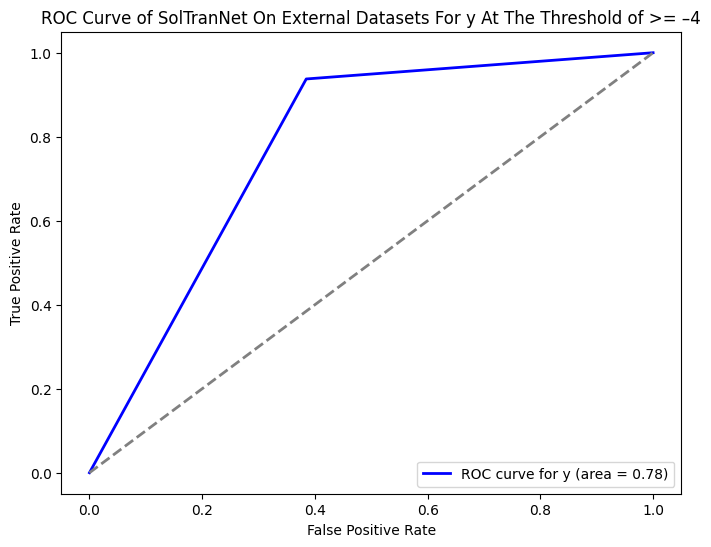

AUROC: 0.776


In [23]:
# binarize y and solubility based on the threshold
threshold = -4

df_pred['y_binary'] = df_pred['y'].apply(lambda x: 1 if x >= threshold else 0)
df_pred['solubility_binary'] = df_pred['solubility'].apply(lambda x: 1 if x >= threshold else 0)
# calculate ROC curve for y
fpr_y, tpr_y, _ = roc_curve(df_pred['y_binary'], df_pred['solubility_binary'])
roc_auc_y = auc(fpr_y, tpr_y)

# plot ROC curve for y
plt.figure(figsize=(8, 6))
plt.plot(fpr_y, tpr_y, color='blue', lw=2, label='ROC curve for y (area = %0.2f)' % roc_auc_y)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of SolTranNet On External Datasets For y At The Threshold of >= –4')
plt.legend(loc='lower right')
plt.savefig('/content/drive/MyDrive/ersilia/figures/sol_vali_roc1a.png')
plt.show()

# Print AUROC and R2 score
print("AUROC:", round(roc_auc_y,3))

*   ***at the threshold of less than –4:***

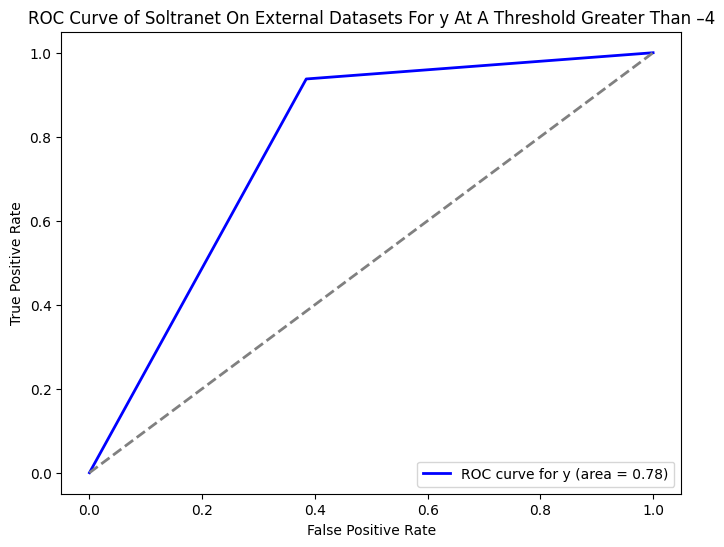

AUROC: 0.776


In [24]:
# binarize y and solubility based on the threshold
threshold = -4
df_pred['y_binary'] = df_pred['y'].apply(lambda x: 1 if x > threshold else 0)
df_pred['solubility_binary'] = df_pred['solubility'].apply(lambda x: 1 if x >= threshold else 0)

# calculate ROC curve for y
fpr_y, tpr_y, _ = roc_curve(df_pred['y_binary'], df_pred['solubility_binary'])
roc_auc_y = auc(fpr_y, tpr_y)

# plot ROC curve for y
plt.figure(figsize=(8, 6))
plt.plot(fpr_y, tpr_y, color='blue', lw=2, label='ROC curve for y (area = %0.2f)' % roc_auc_y)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Soltranet On External Datasets For y At A Threshold Greater Than –4')
plt.legend(loc='lower right')
plt.savefig('/content/drive/MyDrive/ersilia/figures/sol_vali_roc1b.png')
plt.show()

# Print AUROC and R2 score
print("AUROC:", round(roc_auc_y,3))

***COMMENTS:***

*   The values of AURO for y remained the same across both thresholds.

*   An AUROC value of 0.78 is good enough but with more tuning on the model, it can even improve.



**Let's calculate AUC-ROC value and R2 score for Soltranet at both thresholds( >= –4, and < –4) for solubility values**

*  ***at the threshold of greater than or equal to –4:***

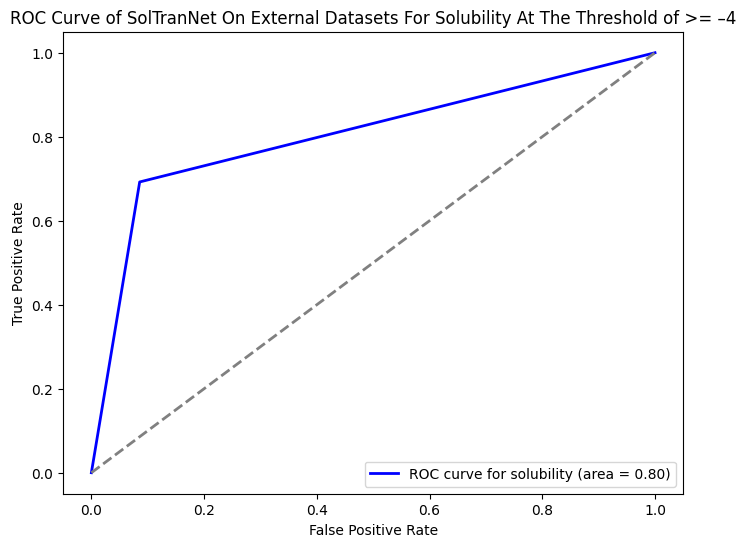

AUROC: 0.803


In [25]:
# binarize y and solubility based on the threshold
threshold = -4
df_pred['y_binary'] = df_pred['y'].apply(lambda x: 1 if x >= threshold else 0)
df_pred['solubility_binary'] = df_pred['solubility'].apply(lambda x: 1 if x >= threshold else 0)

# Calculate ROC curve for Solubility
fpr_solu, tpr_solu, _ = roc_curve(df_pred['solubility_binary'], df_pred['y_binary'])
roc_auc_solu = auc(fpr_solu, tpr_solu)

# Calculate R2 score for Solubility
r2_solu = r2_score(df_pred['solubility_binary'], df_pred['y_binary'])

# plot ROC curve for solubility
plt.figure(figsize=(8, 6))
plt.plot(fpr_solu, tpr_solu, color='blue', lw=2, label='ROC curve for solubility (area = %0.2f)' % roc_auc_solu)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of SolTranNet On External Datasets For Solubility At The Threshold of >= –4')
plt.legend(loc='lower right')
plt.savefig('/content/drive/MyDrive/ersilia/figures/sol_vali_roc2a.png')
plt.show()

# Print AUROC and R2 score
print("AUROC:", round(roc_auc_solu,3))

*  ***at the threshold of less than –4:***

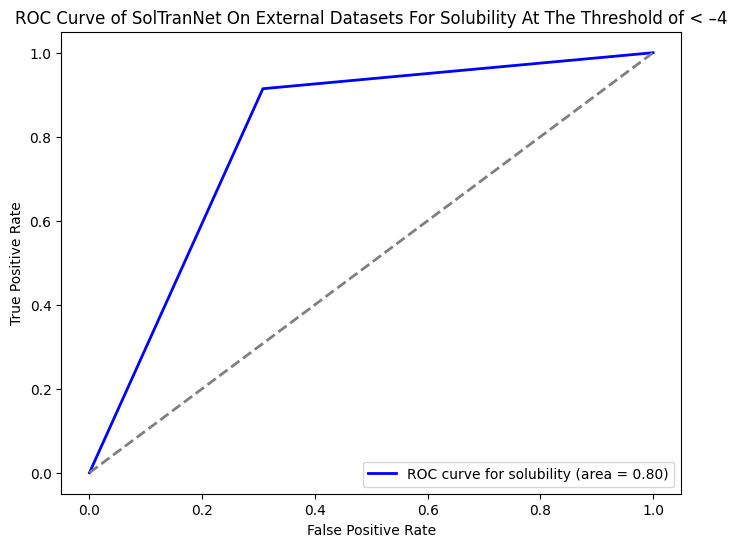

AUROC: 0.803


In [26]:
# binarize y and solubility based on the threshold
threshold = -4
df_pred['y_binary'] = df_pred['y'].apply(lambda x: 1 if x < threshold else 0)
df_pred['solubility_binary'] = df_pred['solubility'].apply(lambda x: 1 if x < threshold else 0)

# Calculate ROC curve for Solubility
fpr_solu, tpr_solu, _ = roc_curve(df_pred['solubility_binary'], df_pred['y_binary'])
roc_auc_solu = auc(fpr_solu, tpr_solu)

# Calculate R2 score for Solubility
r2_solu = r2_score(df_pred['solubility_binary'], df_pred['y_binary'])

# plot ROC curve for solubility
plt.figure(figsize=(8, 6))
plt.plot(fpr_solu, tpr_solu, color='blue', lw=2, label='ROC curve for solubility (area = %0.2f)' % roc_auc_solu)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of SolTranNet On External Datasets For Solubility At The Threshold of < –4')
plt.legend(loc='lower right')
plt.savefig('/content/drive/MyDrive/ersilia/figures/sol_vali_roc2b.png')
plt.show()

# Print AUROC and R2 score
print("AUROC:", round(roc_auc_solu,3))


***COMMENTS:***

*   The values of AURO for solubility remained the same across both thresholds.

*   An AUROC value of 0.80 for solubility is very impressive and better than the value we got for y.



---



# **Sction B: eos6oli Through Ersilia Model Hub**

*   In this section, we will deploy the model through the Ersilia Model Hub and check to see if it produces the same result as what we got from SolTranNet.



**Deploying Ersilia Ersilia Model Hub To Colab, Fetching and Serving The Model of choice, eos6oli**

In [27]:
%%capture
%env MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.12.0-Linux-x86_64.sh
%env MINICONDA_PREFIX=/usr/local
%env PYTHONPATH= "$PYTHONPATH:/usr/local/lib/python3.7/site-packages"
%env PIP_ROOT_USER_ACTION=ignore

In [28]:
!wget https://repo.anaconda.com/miniconda/$MINICONDA_INSTALLER_SCRIPT
!chmod +x $MINICONDA_INSTALLER_SCRIPT
!./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

--2024-03-23 20:28:16--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104996770 (100M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.12.0-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>] 100.13M   162MB/s    in 0.6s    

2024-03-23 20:28:17 (162 MB/s) - ‘Miniconda3-py37_4.12.0-Linux-x86_64.sh’ saved [104996770/104996770]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2022.3.29=h06a4308_1
    - certifi==2021.10.8=py37h06a4308_2
    - cffi==1.15.0=py37hd667e15_1
    

In [29]:
!python -m pip install git+https://github.com/ersilia-os/ersilia.git
!python -m pip install requests --upgrade
!python -m pip install pandas
!rm $MINICONDA_INSTALLER_SCRIPT

  Cloning https://github.com/ersilia-os/ersilia.git to /tmp/pip-req-build-dfuf3tyy
  Running command git clone -q https://github.com/ersilia-os/ersilia.git /tmp/pip-req-build-dfuf3tyy
  Resolved https://github.com/ersilia-os/ersilia.git to commit 8bc77c0917794cf2fc8685fe359301a8348617d7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 139 kB 3.2 MB/s 
     |████████████████████████████████| 9.9 MB 28.4 MB/s 
     |████████████████████████████████| 148 kB 47.3 MB/s 
     |████████████████████████████████| 421 kB 47.7 MB/s 
     |████████████████████████████████| 4.3 MB 19.0 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 97 kB 7.4 MB/s 
     |████████████████████████████████| 670 kB 48.3 MB/s 
     |████████████████████████████████| 78 kB 7.6 MB/s 
     |████████████████████████████████| 58 kB 7.4 MB/s 
     |█████████

In [30]:
import sys
_ = sys.path.append("/usr/local/lib/python3.7/site-packages")

****Let's specify our folders and filenames:****

In [31]:
#specify input folder
input_folder = '/content/drive/MyDrive/ersilia/data/llinas2020/'

#specify the name of the input file
input_filename = "llinas2020_set1_test"

#specify the name of the SMILE column
smiles_column = 'smiles'

In [32]:
# @title Let's check how many number of smiles 😄 we have in our dataset
#let's now extract the SMILES into a List
path = "%s/%s.csv" % (input_folder, input_filename)
smiles_column = "%s" % smiles_column
df = pd.read_csv(path)
smiles = df[smiles_column].tolist()

print(f"My dataset contains {str(len(smiles)) + ' ' + 'SMILES'}")

My dataset contains 100 SMILES


**Let's fetch and serve our model:**


In [33]:
#assign the model to a name
model = "eos6oli"

#let's fetch the model
import time

begin = time.time()
!ersilia fetch $model
end = time.time()

print("Time taken:", round((end - begin), 2), "seconds")

⬇️  Fetching model eos6oli: soltrannet-aqueous-solubility
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
  Running command git clone -q https://github.com/ersilia-os/bentoml-ersilia.git /tmp/pip-req-build-50yi5rtn
Solving environment: \ failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: / - \ | / - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /usr/local/envs/eosbase-bentoml-0.11.0-py37

  added / updated specs:
    - python=3.7


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-5.1          |            1_gnu          21 KB
    ca-certificates-2024.3.11  |      

**Let's serve the model we fetched:**

In [34]:
#serve the model
!ersilia serve $model

sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
🚀 Serving model eos6oli: soltrannet-aqueous-solubility

   URL: http://127.0.0.1:43611
   PID: 5987
   SRV: conda

👉 To run model:
   - run

💁 Information:
   - info


**Let's make predictions on the strange data with our model:**

In [35]:
#let's employ the model to run predictions on the 1000molecules dataset
api = "calculate"

from ersilia import ErsiliaModel
import time

model = ErsiliaModel(model)
begin = time.time()
output = model.api(input=smiles, output="pandas")
end = time.time()

print("Successful 👍! Time taken:", round((end - begin), 2),
      "seconds")
model.close()

Successful 👍! Time taken: 12.4 seconds


In [36]:
# @title 👀 Let's view the predicted output
output

,key,input,solubility
0,BZKPWHYZMXOIDC-UHFFFAOYSA-N,CC(NC1=NN=C(S1)[S](N)(=O)=O)=O,-1.242
1,BSYNRYMUTXBXSQ-UHFFFAOYSA-N,C(C)(=O)OC1=CC=CC=C1C(=O)O,-1.858
2,ARHWPKZXBHOEEE-UHFFFAOYSA-N,C=CCOc1ccc(cc1Cl)CC(=O)O,-3.120
3,JBDGDEWWOUBZPM-XYPYZODXSA-N,O[C@@H]2CC[C@@H](NCc1cc(Br)cc(Br)c1N)CC2,-2.199
4,CEUORZQYGODEFX-UHFFFAOYSA-N,O=C1Nc2c(ccc(OCCCCN3CCN(c4c(Cl)c(Cl)ccc4)CC3)c...,-5.205
...,...,...,...
95,SRVJKTDHMYAMHA-WUXMJOGZSA-N,C1=C(C=CC(=C1)NC(=O)C)/C=N/NC(=S)N,-3.015
96,GFNANZIMVAIWHM-OBYCQNJPSA-N,[C@]23([C@H]([C@H]1[C@]([C@](C(CO)=O)(O)[C@@H]...,-2.419
97,FNYLWPVRPXGIIP-UHFFFAOYSA-N,C3=C(C1=C(N=C2C(=N1)C(=NC(=N2)N)N)N)C=CC=C3,-3.734
98,QTXVAVXCBMYBJW-UHFFFAOYSA-N,C3=C(C(C1=C(OC2=C(C1=O)C=CC=C2)O)CC(=O)C)C=CC=C3,-4.905


In [37]:
# @title 🗃️ let's save the output dataframe into a CSV file that will store our predictions
path = '/content/drive/MyDrive/ersilia/data/eos_vali_output.csv'
output.to_csv(path, sep=',', index=False, encoding='utf-8')

In [38]:
# Load the output data from the saved CSV file
output_path = "/content/drive/MyDrive/ersilia/data/eos_vali_output.csv"
eos_df = pd.read_csv(output_path)
print(eos_df.head())

                           key  \
0  BZKPWHYZMXOIDC-UHFFFAOYSA-N   
1  BSYNRYMUTXBXSQ-UHFFFAOYSA-N   
2  ARHWPKZXBHOEEE-UHFFFAOYSA-N   
3  JBDGDEWWOUBZPM-XYPYZODXSA-N   
4  CEUORZQYGODEFX-UHFFFAOYSA-N   

                                               input  solubility  
0                     CC(NC1=NN=C(S1)[S](N)(=O)=O)=O      -1.242  
1                         C(C)(=O)OC1=CC=CC=C1C(=O)O      -1.858  
2                           C=CCOc1ccc(cc1Cl)CC(=O)O      -3.120  
3           O[C@@H]2CC[C@@H](NCc1cc(Br)cc(Br)c1N)CC2      -2.199  
4  O=C1Nc2c(ccc(OCCCCN3CCN(c4c(Cl)c(Cl)ccc4)CC3)c...      -5.205  


# Model(eso6oli) Bias Evaluation:

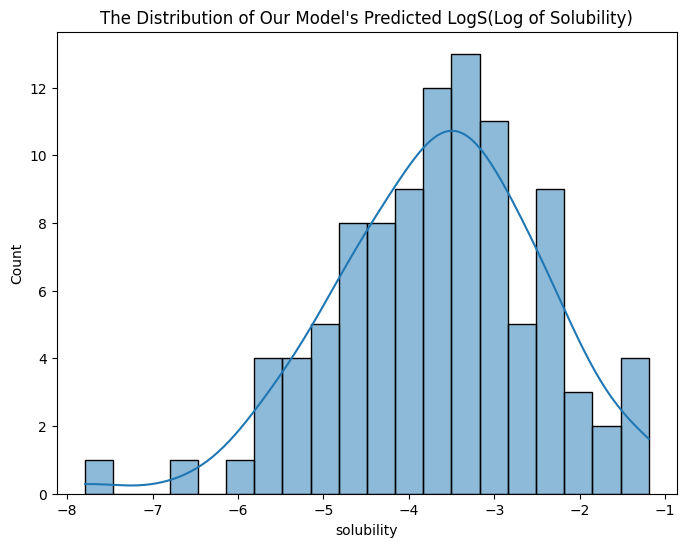

In [39]:
# @title 📊 Let's employ a histogram plot to visualize the distribution of our predictions
fig = plt.figure(figsize=(8,6))
sns.histplot(data=eos_df, x='solubility', bins=20, kde=True)
plt.title("The Distribution of Our Model's Predicted LogS(Log of Solubility)")
plt.savefig('/content/drive/MyDrive/ersilia/figures/eos6oli_vali_hist_plot.png')
plt.show();

In [40]:
# @title let's import a function called solubility_category which will help categorise the solubility values
from functions import solubility_category

Slightly Soluble    58
Insoluble           35
Soluble              7
Name: solubility_cat, dtype: int64


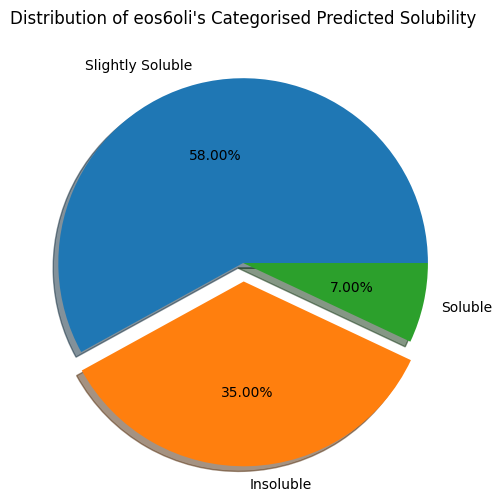

In [42]:
# @title let's visualise with pie chart

#copy the dataframe
df_new = eos_df.copy()

# apply the solub function to create a new column
df_new['solubility_cat'] = df_new['solubility'].apply(solubility_category)

#let's visualize the distribution according to their degree of solubility
degree_of_solubility = df_new.solubility_cat.value_counts()
print(degree_of_solubility)

#create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    labels = degree_of_solubility.index,
    x = degree_of_solubility.values,
    shadow=True,
    autopct = "%.2f%%",
    explode = (0, 0.1,0)
)
plt.title("Distribution of eos6oli's Categorised Predicted Solubility")
plt.savefig('/content/drive/MyDrive/ersilia/figures/eos6oli_vali_pie_chart.png')
plt.show();

# Model's(eos6oli) Performance Evaluation:

In [51]:
# @title ✍️ Let's rename the solubility column from the both DataFrames and merge the DataFrames together

#load the original data into a dataframe
df_old = pd.read_csv('/content/drive/MyDrive/ersilia/data/llinas2020/llinas2020_set1_test.csv')

#copy the new dataframe
df_New = eos_df.copy()

df_old.rename(columns={'y': 'actual_solubility'}, inplace=True)
df_New.rename(columns={'solubility':'predicted_solubility'}, inplace=True)

# Merge ➕ both molecules_df and output into a single DataFrame
merged_df = pd.merge(df_old, df_New, how='left', left_on='smiles', right_on='input')
merged_df.drop(columns=['smiles'], inplace=True)
merged_df.head()

,actual_solubility,key,input,predicted_solubility
0,-2.38,BZKPWHYZMXOIDC-UHFFFAOYSA-N,CC(NC1=NN=C(S1)[S](N)(=O)=O)=O,-1.242
1,-1.67,BSYNRYMUTXBXSQ-UHFFFAOYSA-N,C(C)(=O)OC1=CC=CC=C1C(=O)O,-1.858
2,-4.40,ARHWPKZXBHOEEE-UHFFFAOYSA-N,C=CCOc1ccc(cc1Cl)CC(=O)O,-3.120
3,-3.87,JBDGDEWWOUBZPM-XYPYZODXSA-N,O[C@@H]2CC[C@@H](NCc1cc(Br)cc(Br)c1N)CC2,-2.199
4,-6.64,CEUORZQYGODEFX-UHFFFAOYSA-N,O=C1Nc2c(ccc(OCCCCN3CCN(c4c(Cl)c(Cl)ccc4)CC3)c...,-5.205


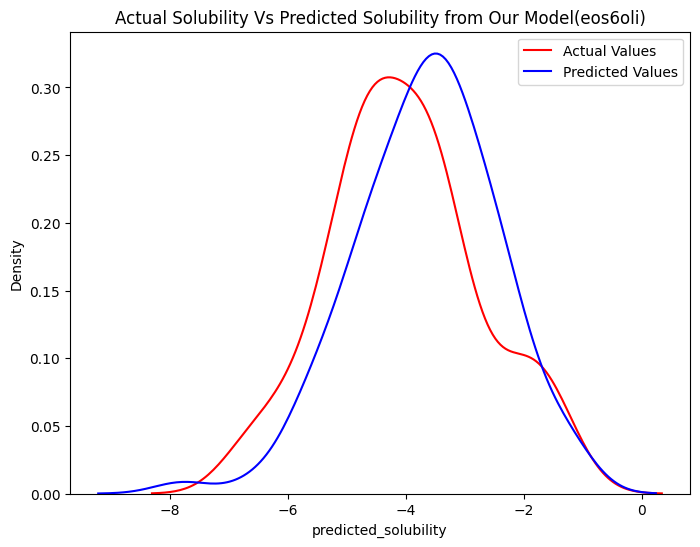

In [52]:
# @title 📈 Let's visualize how close our predicted log of solubility is to the actual log of solubility
fig = plt.figure(figsize=(8,6))
ax = sns.distplot(merged_df['actual_solubility'], color='r', label='Actual Values', hist=False)
sns.distplot(merged_df['predicted_solubility'], color='b', label='Predicted Values', hist=False, ax=ax)
plt.title('Actual Solubility Vs Predicted Solubility from Our Model(eos6oli)')
plt.legend()
plt.savefig('/content/drive/MyDrive/ersilia/figures/eos6oli_vali_dist_plot.png')
plt.show();

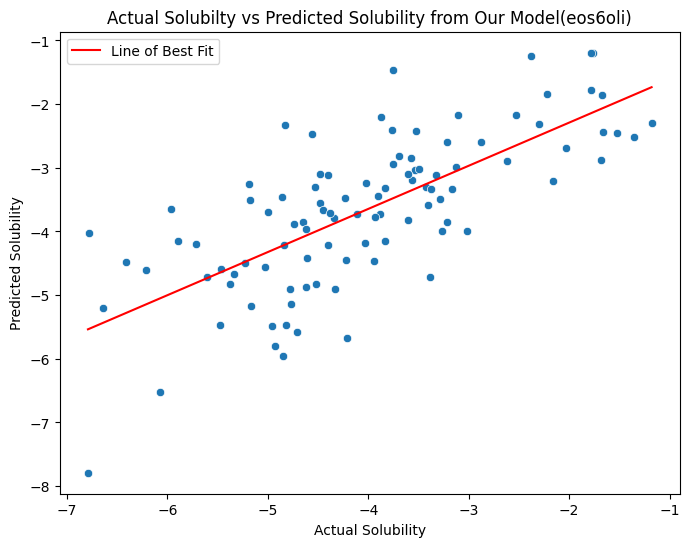

In [54]:
# @title Let's generate a scatter plot to further show how closely related our model's predictions are to the actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='actual_solubility', y='predicted_solubility', data=merged_df)

#import LinearRegression
from sklearn.linear_model import LinearRegression

# adding a line of best fit
model = LinearRegression()
model.fit(merged_df[['actual_solubility']], merged_df['predicted_solubility'])
x_values = np.linspace(merged_df['actual_solubility'].min(), merged_df['actual_solubility'].max(), 100)
y_values = model.predict(x_values.reshape(-1, 1))
plt.plot(x_values, y_values, color='red', label='Line of Best Fit')

plt.legend()
plt.title('Actual Solubilty vs Predicted Solubility from Our Model(eos6oli)')
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubility')

plt.savefig('/content/drive/MyDrive/ersilia/figures/eos6oli_vali_scatter_plot.png')
plt.show()

In [55]:
# @title Let's evaluate eos6oli's performance metrics

MAE = mean_absolute_error(merged_df['actual_solubility'], merged_df['predicted_solubility'])
MSE = mean_squared_error(merged_df['actual_solubility'], merged_df['predicted_solubility'])
RMSE = np.sqrt(MSE)
R2_Score = r2_score(merged_df['actual_solubility'], merged_df['predicted_solubility'])

print(f'MAE: {MAE:.2f}')
print(f'MSE: {MSE:.2f}')
print(f'RMSE: {RMSE:.2f}')
print(f'R2_Score: {R2_Score:.2f}')

MAE: 0.79
MSE: 0.98
RMSE: 0.99
R2_Score: 0.39




---



# **Conclusion:**

*   All the visualisations, and values from the model's evaluation remained the same when the model was deployed through SolTranNet and when it was deployed through Ersilia Model Hub. Hence, this has confirmed that the model provides the same results across both ways.
*   However, the only difference I noticed was that the model ran faster through SolTranNet than it did through Ersilia Model Hub.

*   Overall, we have successfully validated the model with a strange dataset.

